# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [287]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np 
# import matplotlib.pyplot as plt
import pylab as pl
import zipfile 
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
try:
    import urllib2 as urlib
except ImportError:
    import urllib as urlib
import requests
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "{}/Desktop/PUI/PUIDATA".format(os.getenv("HOME"))
#     os.environ["PUIDATA"] = "{}/PUIDATA".format(os.getenv("HOME"))
    puidata = os.getenv("PUIDATA")
    print("Warning: PUIDATA environmental variable not found and set by code, please review!")
print("PUIDATA: {}".format(puidata))

PUIDATA: /Users/soham/Desktop/PUI/PUIDATA


In [4]:
## Getting the zipcodes
url = \
    'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
filename = 'zipcodes.zip'
#Check if file exists
if not os.path.isfile(puidata + "/" + filename):
    print ("Downloading file")
    #Use this for some reason instead of curl, maybe because the url doesn't point to a file but generates it
    urlib.request.urlretrieve(url, filename)
    os.system("mv " + filename + " " + puidata)

#Unzip file
print ("Unzipping file")
os.system("unzip " + puidata + "/" + filename + " -d " + puidata + '/NYC_Zipcodes/')

#Get the file names from the .zip
files = os.popen("unzip -Z1 " + puidata + "/" + filename).read()
files = files.split(sep='\n')
shp_file = files[1]

if not os.path.isfile(puidata + "/NYC_Zipcodes/" + shp_file):
    print('Warning: file is not there, something went wrong!')
else:
    print('Files in place, please continue')

Unzipping file
Files in place, please continue


In [5]:
#Function for downloading data
def getBuraeuBizData(year):
    if len(year) != 2: # Check input 
        print('Error: Enter appropriate year(2 digits)')
        return
    filename_zip = 'zbp{}totals.zip'.format(year)
    filename = 'zbp{}totals.txt'.format(year)
    # check for file
    if not os.path.isfile(puidata + "/" + filename):
        #Check zip
        if not os.path.isfile(puidata + "/" + filename_zip):
            #Download zip and move to puidata
            print ("Downloading file") 
            os.system("curl -L -O " +
                "https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/" +\
                     filename_zip )#+ "?raw=true >" + filename_zip)
            os.system("mv " + filename_zip + " " + puidata) #+ "/BuraeuBiz/")
        # Unzip and move to puidata
        print ("Unzipping file") 
        zf = zipfile.ZipFile(puidata + "/" + filename_zip)


    # Check:
#     if not os.path.isfile(puidata + "/BuraeuBiz/" + filename):
#         print ("WARNING!!! Something is wrong: the file is not there!")

#     else:
#         print ("File in place, you can continue")
    df = pd.read_csv(zf.open(filename_zip.replace('.zip','.txt')))
    return(df)



# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [7]:
import geopandas as gpd
nyczipsshp = gpd.read_file(os.getenv("PUIDATA") + "/NYC_Zipcodes/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [8]:
nyczipsshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [9]:
nyczipsshp.ZIPCODE = nyczipsshp.ZIPCODE.astype('int')

In [10]:
cbs = getBuraeuBizData('00') # Initializing the dataframe

Unzipping file


In [11]:
cbs.head()

,ZIP,NAME,EMPFLAG,EMP,QP1,AP,EST
0,501,"HOLTSVILLE, NY",A,0,0,0,1
1,1001,"AGAWAM, MA",NaN,8042,59833,259661,493
2,1002,"AMHERST, MA",NaN,6547,36719,169658,563
3,1003,"AMHERST, MA",NaN,82,308,2482,13
4,1004,"AMHERST, MA",NaN,717,2049,5826,48


In [12]:
cbs = nyczipsshp.merge(cbs,how='left',left_on = 'ZIPCODE',right_on = 'ZIP')[['ZIPCODE','geometry','EST']]
cbs.rename({'EST':'EST00'},axis=1,inplace=True)

In [13]:
cbs.head()

,ZIPCODE,geometry,EST00
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",65.0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",477.0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",520.0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",417.0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",1161.0


In [14]:
LowerCase = [3,4,5,6,7,8,9]
UpperCase = [98,99]

In [15]:
# Getting all the files in
for i in range(1,10):
    print('0'+str(i))
    if i in LowerCase:
        cbs = cbs.merge(getBuraeuBizData('0'+str(i)),how='left',left_on = 'ZIPCODE'\
                    ,right_on = 'zip')
#         cbs.drop(cbs.iloc[:,len(cbs.columns)-7:len(cbs.columns)-1],axis=1,inplace=True)
        cbs.rename({'est':'EST{}'.format('0'+str(i))},axis=1,inplace=True)
    else:
        cbs = cbs.merge(getBuraeuBizData('0'+str(i)),how='left',left_on = 'ZIPCODE'\
                    ,right_on = 'ZIP')
        cbs.rename({'EST':'EST{}'.format('0'+str(i))},axis=1,inplace=True)

for i in range(10,15):
    print(i)
    cbs = cbs.merge(getBuraeuBizData(str(i)),how='left',left_on = 'ZIPCODE'\
                    ,right_on = 'zip')
    cbs.rename({'est':'EST{}'.format(str(i))},axis=1,inplace=True)

for i in range(94,100):
    print(i)
    if i in UpperCase:
        cbs = cbs.merge(getBuraeuBizData(str(i)),how='left',left_on = 'ZIPCODE'\
                    ,right_on = 'ZIP')
        cbs.rename({'EST':'EST{}'.format(str(i))},axis=1,inplace=True)
    else:
        cbs = cbs.merge(getBuraeuBizData(str(i)),how='left',left_on = 'ZIPCODE'\
                    ,right_on = 'zip')
        cbs.rename({'est':'EST{}'.format(str(i))},axis=1,inplace=True)
    

01
Unzipping file
02
Unzipping file
03
Unzipping file
04
Unzipping file
05
Unzipping file
06
Unzipping file
07
Unzipping file
08
Unzipping file
09
Unzipping file
10
Unzipping file
11
Unzipping file
12
Unzipping file
13
Unzipping file
14
Unzipping file
94
Unzipping file
95
Unzipping file
96
Unzipping file
97
Unzipping file
98
Unzipping file
99
Unzipping file


In [16]:
cbs.head()

,ZIPCODE,geometry,EST00,ZIP_x,NAME_x,EMPFLAG_x,EMP_x,QP1_x,AP_x,EST01,...,QP1_x,AP_x,EST98,ZIP_y,NAME_y,EMPFLAG_y,EMP_y,QP1_y,AP_y,EST99
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",65.0,11436.0,"JAMAICA, NY",NaN,1099.0,4787.0,23387.0,57.0,...,2730.0,12233.0,51.0,11436.0,"JAMAICA, NY",NaN,673.0,2987.0,13658.0,58.0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",477.0,11213.0,"BROOKLYN, NY",NaN,4121.0,31824.0,135498.0,493.0,...,34696.0,144293.0,476.0,11213.0,"BROOKLYN, NY",NaN,4050.0,26729.0,119603.0,473.0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",520.0,11212.0,"BROOKLYN, NY",NaN,9060.0,73718.0,312117.0,527.0,...,79868.0,334713.0,519.0,11212.0,"BROOKLYN, NY",NaN,10074.0,74717.0,325361.0,541.0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",417.0,11225.0,"BROOKLYN, NY",NaN,3173.0,17222.0,77224.0,422.0,...,15570.0,69267.0,416.0,11225.0,"BROOKLYN, NY",NaN,3165.0,16033.0,68930.0,409.0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",1161.0,11218.0,"BROOKLYN, NY",NaN,10365.0,61446.0,243619.0,1180.0,...,45565.0,209737.0,1118.0,11218.0,"BROOKLYN, NY",NaN,9711.0,50115.0,223674.0,1149.0


In [68]:
to_keep = ['ZIPCODE','geometry']

In [69]:
for i in range(94,100):
    to_keep.append('EST'+str(i)) 

In [70]:
for i in range(0,10):
    to_keep.append('EST'+'0'+str(i)) 

In [71]:
for i in range(10,15):
    to_keep.append('EST'+str(i)) 

In [72]:
to_keep

['ZIPCODE',
 'geometry',
 'EST94',
 'EST95',
 'EST96',
 'EST97',
 'EST98',
 'EST99',
 'EST00',
 'EST01',
 'EST02',
 'EST03',
 'EST04',
 'EST05',
 'EST06',
 'EST07',
 'EST08',
 'EST09',
 'EST10',
 'EST11',
 'EST12',
 'EST13',
 'EST14']

In [73]:
cbs = cbs[to_keep]

In [75]:
# 20 years of data and 263 zipcodes
cbs.shape

(263, 23)

In [76]:
cleancsb = cbs.dropna()
cleancsb.index = cleancsb.ZIPCODE
cleancsb.drop(['ZIPCODE','geometry'],axis=1,inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [77]:
#cleaning all missing values
cleancsb.shape

(243, 21)

In [78]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T


vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [79]:
#cluster with kmeans
nc = 4
km = KMeans(n_clusters=nc, random_state=444).fit(vals)


In [80]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

(243,)

In [81]:
centres = km.cluster_centers_

In [250]:
vals_clustered = vals.copy()

In [254]:
vals_clustered['labels'] = km.labels_

In [255]:
vals_clustered_with_geom = vals_clustered.merge(cbs[['ZIPCODE','geometry']],on='ZIPCODE',how='left')

### The map of the clusters may look something like this

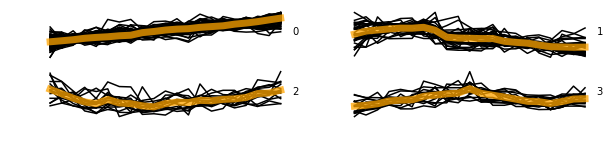

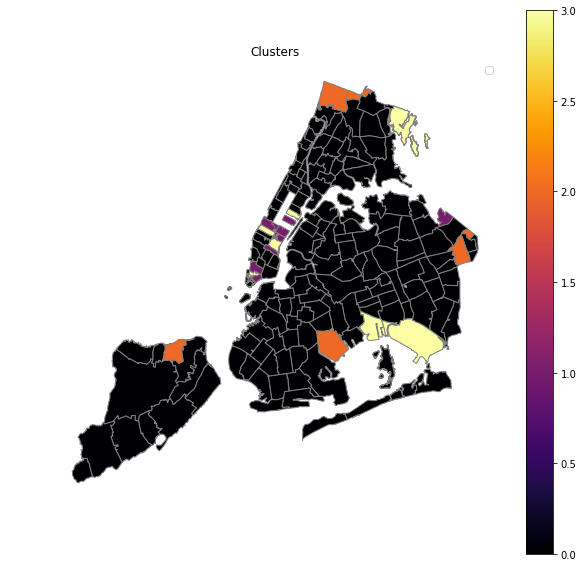

In [265]:
fig = plt.figure(figsize=(10,2))


for i in range(0,4):
    a = vals_clustered.loc[vals_clustered['labels']==i].iloc[:,:len(vals_clustered.columns)-1]
    ax = fig.add_subplot(221+i)
    ax.axis('off')
    ax.annotate('{}'.format(i),xy=(1,1),xytext=(1, 0.5),textcoords='axes fraction')
    for index,row in a.iterrows():
        plt.plot(range(len(vals_clustered.columns)-1),row,c='black')
    plt.plot(range(len(vals_clustered.columns)-1),centres[i],c='orange',lw=7,alpha=0.75)
    

fig,ax = plt.subplots(figsize=(10,10))
vals_clustered_with_geom.plot(column='labels',ax=ax,  edgecolor='grey',  cmap='inferno',legend=True)
plt.title('Clusters')
ax.axis('off')
ax.legend(['0','1','2','3'])


#Correct aspect ratio
# ax.axes.set_aspect('equal')

plt.show()

### Figure 3: 
cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

In [277]:
#cluster with kmeans
nc = 5
km = KMeans(n_clusters=nc, random_state=444).fit(vals)


In [278]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

(243,)

In [279]:
centres = km.cluster_centers_

In [282]:
vals_clustered = vals.copy()

In [283]:
vals_clustered['labels'] = km.labels_

In [284]:
vals_clustered_with_geom = vals_clustered.merge(cbs[['ZIPCODE','geometry']],on='ZIPCODE',how='left')

### The map of the clusters may look something like this

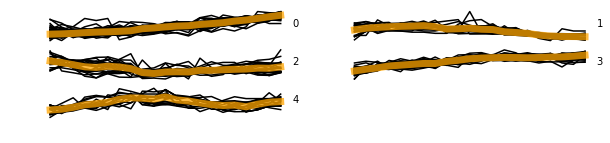

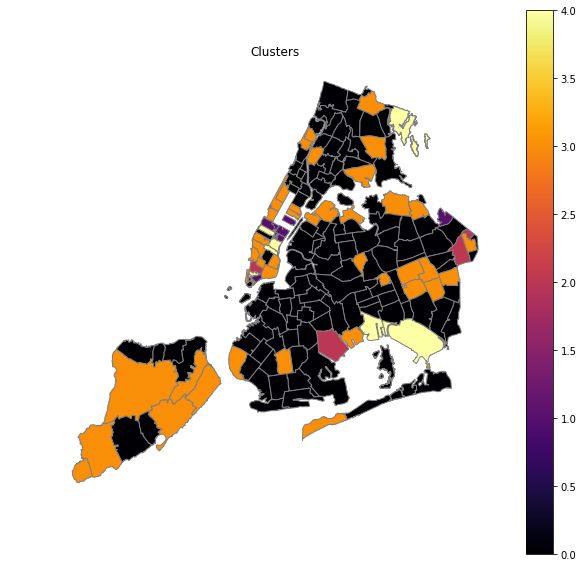

In [286]:
fig = plt.figure(figsize=(10,2))


for i in range(0,5):
    a = vals_clustered.loc[vals_clustered['labels']==i].iloc[:,:len(vals_clustered.columns)-1]
    ax = fig.add_subplot(321+i)
    ax.axis('off')
    ax.annotate('{}'.format(i),xy=(1,1),xytext=(1, 0.5),textcoords='axes fraction')
    for index,row in a.iterrows():
        plt.plot(range(len(vals_clustered.columns)-1),row,c='black')
    plt.plot(range(len(vals_clustered.columns)-1),centres[i],c='orange',lw=7,alpha=0.75)
    

fig,ax = plt.subplots(figsize=(10,10))
vals_clustered_with_geom.plot(column='labels',ax=ax,  edgecolor='grey',  cmap='inferno',legend=True)
plt.title('Clusters')
ax.axis('off')
# ax.legend(['0','1','2','3'])


#Correct aspect ratio
# ax.axes.set_aspect('equal')

plt.show()

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

(905410.75604293647,
 1075212.5382562787,
 112386.35181947277,
 280345.45402395504)

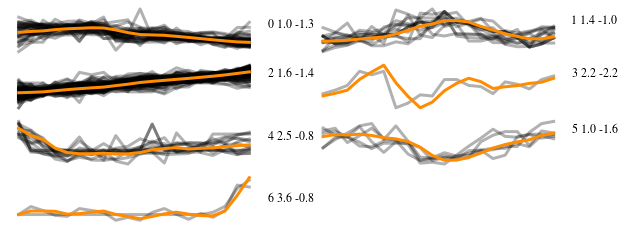

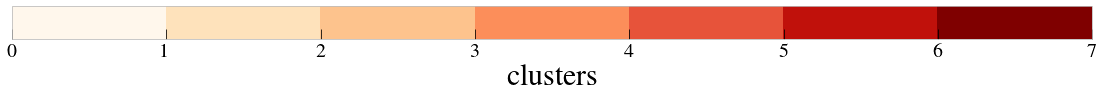

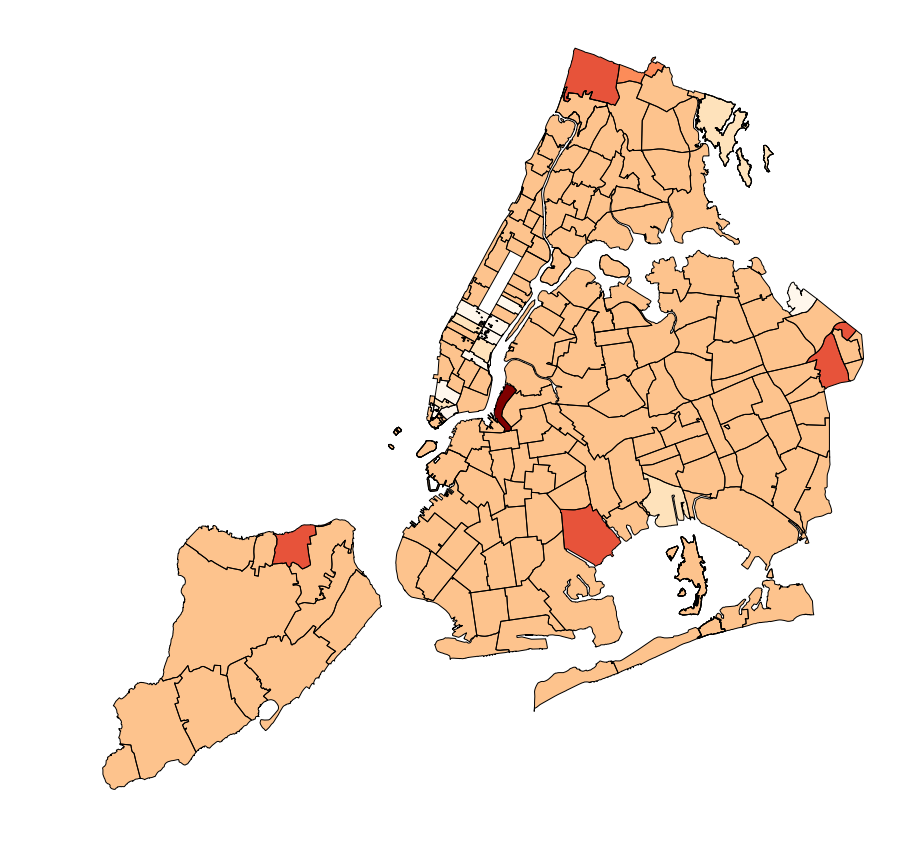

In [29]:
...

### Figure 9: 
As figures 3, 5, 7 for hierarchical agglomerative clustering in 7 clusters, with smoothed time series

# If you want to use agglomerative clustering

In [307]:
nc =7
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals)
labelsag = agc.labels_
centroidsag = np.zeros((nc, vals.shape[1]))



In [303]:
def getCentroid(points):
    return np.nanmean(points[:,0]), np.nanmean(points[:,1])

In [314]:
vals_clustered_agc = vals.copy()

In [322]:
vals_clustered_agc['labels'] = labelsag

In [317]:
# vals_clustered_agc

In [332]:
# vals_clustered_agc[vals_clustered_agc['labels'] == 2]

In [333]:
for i in labelsag:
    centroidsag[i] = getCentroid(vals_clustered_agc[vals_clustered_agc['labels'] == i])

TypeError: unhashable type: 'slice'

In [292]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
agc.labels_.shape

(243,)

In [300]:
agc.get_params()

{'affinity': 'euclidean',
 'compute_full_tree': 'auto',
 'connectivity': None,
 'linkage': 'average',
 'memory': None,
 'n_clusters': 7,
 'pooling_func': <function numpy.core.fromnumeric.mean(a, axis=None, dtype=None, out=None, keepdims=<class 'numpy._globals._NoValue'>)>}

In [297]:
vals_clustered_with_geom_agc = vals_clustered_agc.merge(cbs[['ZIPCODE','geometry']],on='ZIPCODE',how='left')

### The map of the clusters may look something like this

IndexError: index 5 is out of bounds for axis 0 with size 5

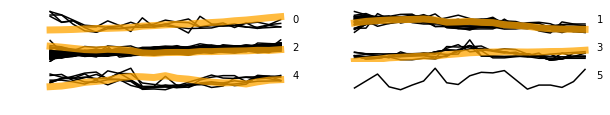

In [302]:
fig = plt.figure(figsize=(10,2))


for i in range(0,7):
    a = vals_clustered_agc.loc[vals_clustered_agc['labels']==i].iloc[:,:len(vals_clustered_agc.columns)-1]
    ax = fig.add_subplot(421+i)
    ax.axis('off')
    ax.annotate('{}'.format(i),xy=(1,1),xytext=(1, 0.5),textcoords='axes fraction')
    for index,row in a.iterrows():
        plt.plot(range(len(vals_clustered.columns)-1),row,c='black')
    plt.plot(range(len(vals_clustered.columns)-1),centres[i],c='orange',lw=7,alpha=0.75)
    

fig,ax = plt.subplots(figsize=(10,10))
vals_clustered_with_geom.plot(column='labels',ax=ax,  edgecolor='grey',  cmap='inferno',legend=True)
plt.title('Clusters')
ax.axis('off')
# ax.legend(['0','1','2','3'])


#Correct aspect ratio
# ax.axes.set_aspect('equal')

plt.show()

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

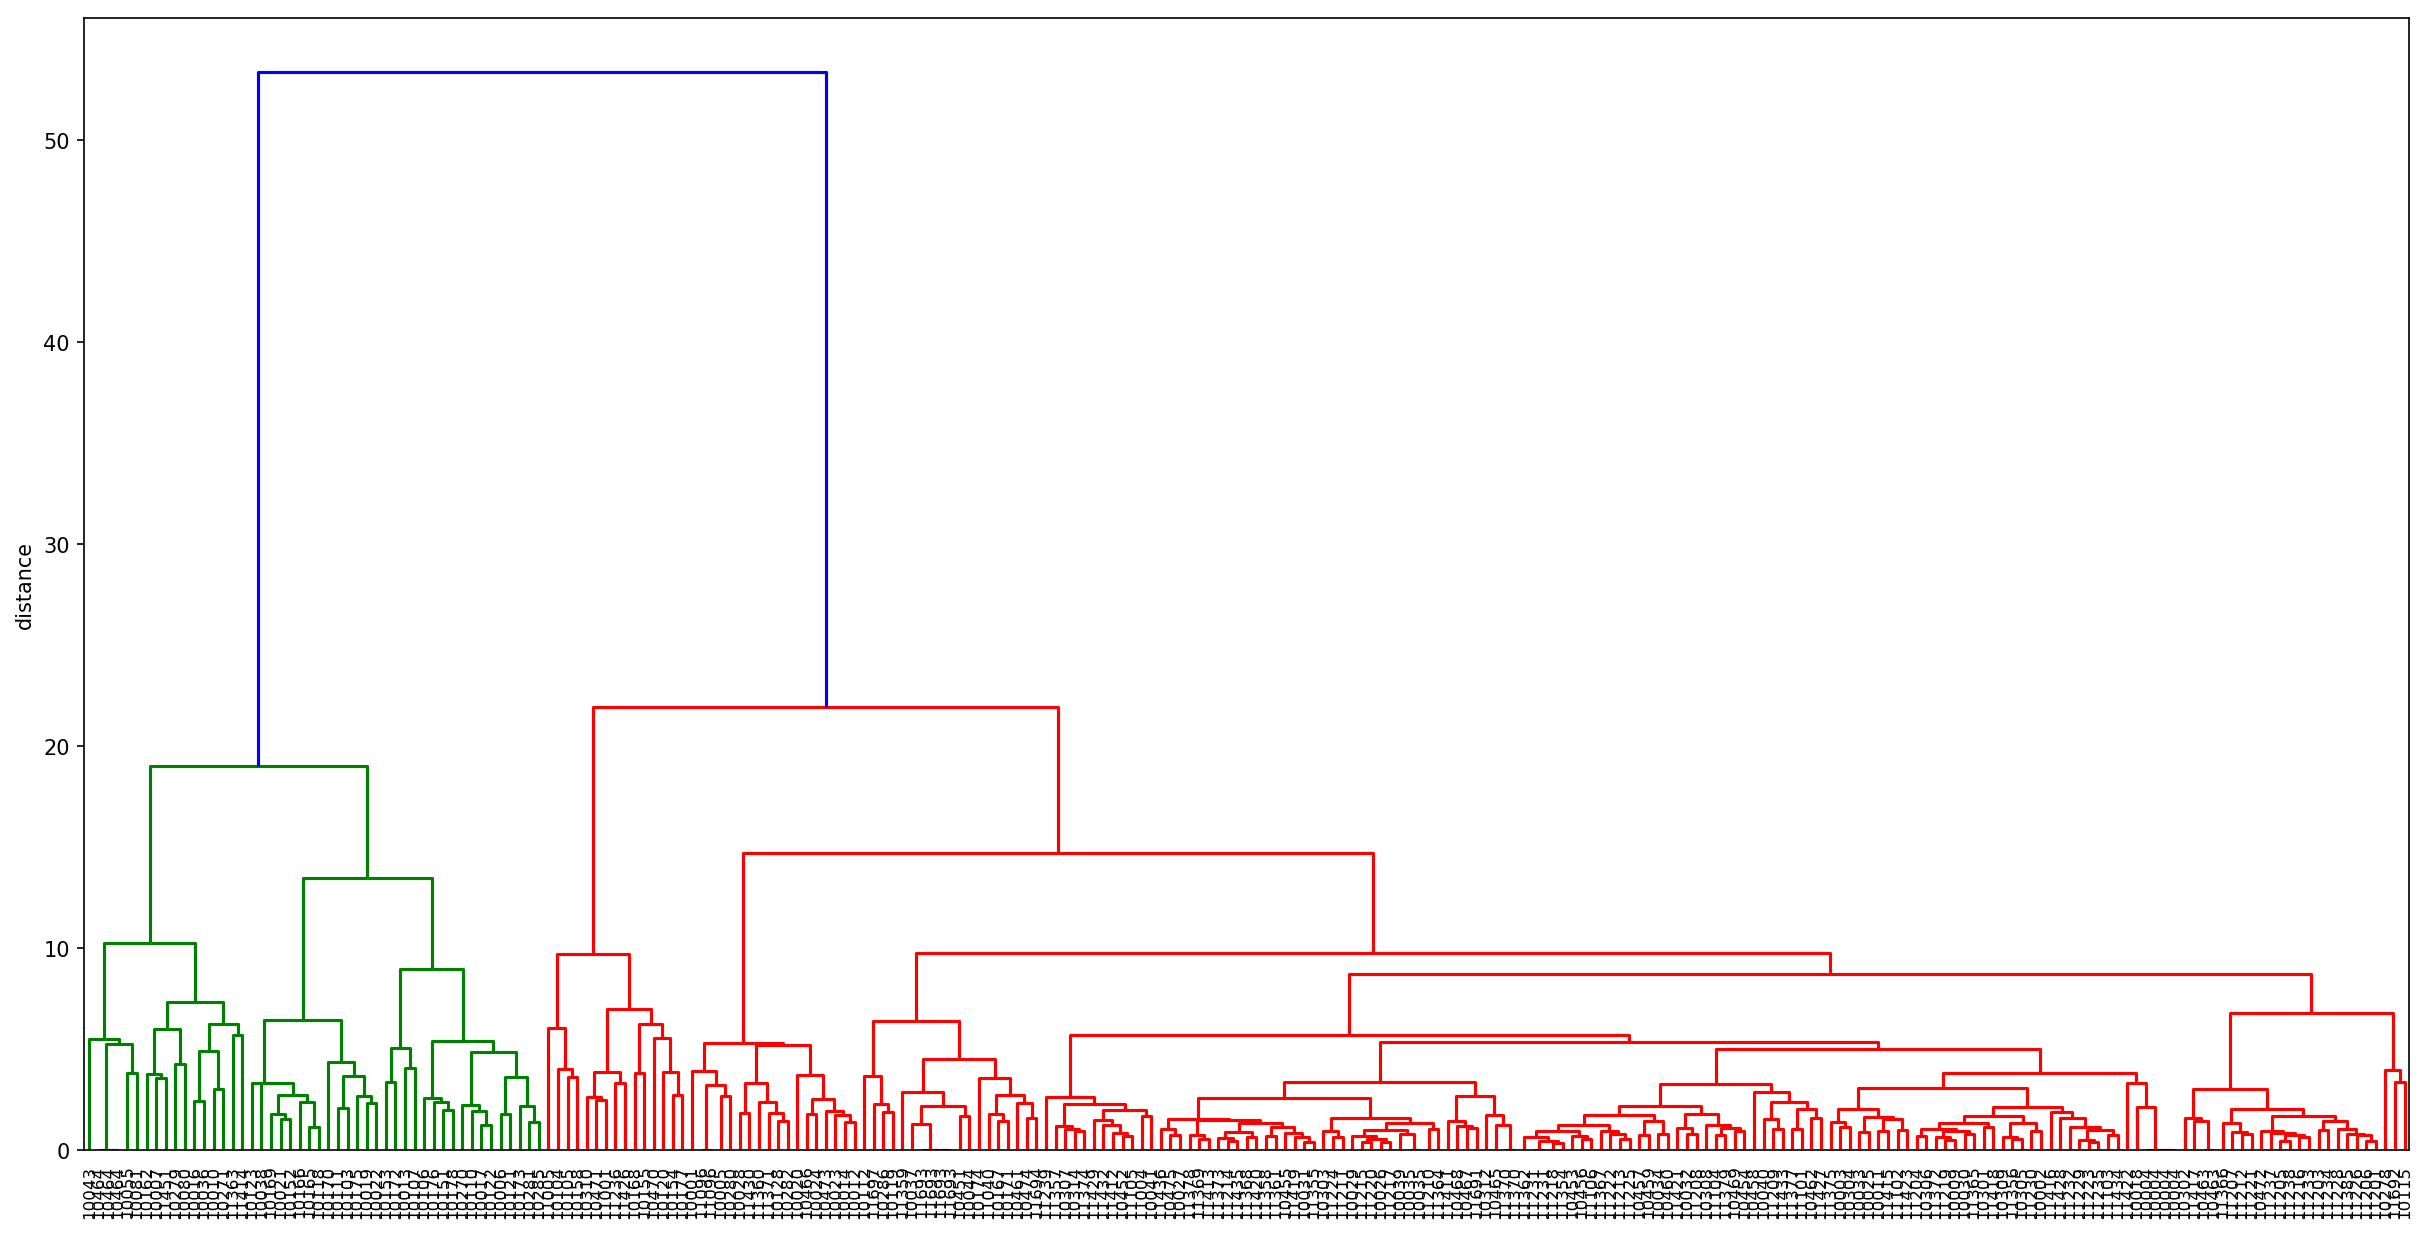

In [338]:
import scipy.cluster as scp
fig = pl.figure(figsize=(20,10), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = (vals.index),
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)


In [20]:
!pwd

/nfshome/fb55/PUI2017_fb55/HW11_fb55


<function scipy.cluster.hierarchy.complete(y)>